# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений разреженных матриц.

In [78]:
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
import math
from scipy.sparse.linalg import norm as sparse_norm
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds
from scipy.sparse import find

%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/HIjLehGZEcCRig) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [79]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [80]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [81]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше). 
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Для начала выведите необходимые формулы аналитически, а затем реализуйте их в коде. Ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо.  Везде считайте $r < m, n$.

**Объяснение**:

Распишем квадрат искомой нормы подробнее:

$||A-UV^T||_F^2=tr((A-UV^T)^T(A-UV^T))=tr((A^T-VU^T)(A-UV^T))=tr(A^TA-A^TUV^T-VU^TA+VU^TUV^T)=tr(A^TA)-tr(A^TUV^T)-tr(VU^TA)+tr(VU^TUV^T)=||A||_F^2-2tr(U^TAV)+tr(V^TVU^TU)$

1) Первое слагаемое мы уже знаем - это квадрат данной нам нормы

2) Второе слагаемое: $(U^TA)\in \mathbb{R}^{r\times n}$ мы умеем считать быстро; $V\in \mathbb{R}^{n\times r} \implies$ умножение $(U^TA)V \in \mathbb{R}^{r\times r}$ мы реализуем за $O(nr^2)$ ($r^2$ раз посчитаем скалярое произведение векторов длины $n$)

3) Третье слагаемое: $U^TU \in \mathbb{R}^{r\times r}$ умножим за $O(mr^2)$ ($r^2$ раз посчитаем скалярое произведение векторов длины $m$)

$V^TV \in \mathbb{R}^{r\times r}$ умножим за $O(nr^2)$ ($r^2$ раз посчитаем скалярое произведение векторов длины $n$)

$(V^TV)(U^TU) \in \mathbb{R}^{r\times r}$ умножим за $O(r^3)$ ($r^2$ раз посчитаем скалярое произведение векторов длины $r$)

Значит, мы на каждом шаге укладываемся в разрешенную сложность.

Чтобы получить искомую норму, нам останется только сложить все 3 слагаемых и извлечь корень.

In [82]:
def als_functional(A, A_norm, U, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, VT: 2D arrays such that U @ VT approximates A
        Output
            ||A - U VT||_F
    """
    result=A_norm**2 #Добавили первое слагаемое
    result-=2*np.trace((U.T@A)@VT.T) #Добавили второе слагаемое
    result+=np.trace((VT@VT.T)@(U.T@U)) #Добавили третье слагаемое
        
    return math.sqrt(result)    

**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** *Расстоянием от подпространства* $L_1 \subset \mathbb{R}^m$ *до подпространства* $L_2 \subset \mathbb{R}^m$ будем называть число $\|(I - P(L_1)) P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Функция несимметричная, так что будьте осторожны с расстановкой аргументов. Опишите алгоритм вычисления расстояния от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^\top U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

**Объяснение:**

Если матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ состоят из ортонормированных столбцов, то они полного ранга ($rk(U_1)=rk(U_2)=r$). Более того, в силу ортонормированности столбцов данных матриц получаем: $U_1^TU_1=I_r \in \mathbb{R}^{r\times r}; U_2^TU_2=I_r\in \mathbb{R}^{r\times r}$.

Тогда по утверждению 4 из лекции 4 получаем: $P(Im(U_1))=U_1(U_1^TU_1)^{-1}U_1^T=U_1(I_r)^{-1}U_1^T=U_1U_1^T$, и по аналогии $P(Im(U_2))=U_2U_2^T$

Тогда расстояние между подпространствами можно представить в виде: $dist(Im(U_1), Im(U_2)) = ||(I-U_1U_1^T)U_2U_2^T||_2=||(U_2-U_1U_1^TU_2)U_2^T||_2$

Заметим, что матрицу $U_1^TU_2 \in \mathbb{R}^{r\times r}$ мы посчитаем за $O(r^2m)$ ($r^2$ раз посчитать скалярное произведение векторов длины $m$). Матрицу $U_1(U_1^TU_2) \in \mathbb{R}^{m\times r}$ мы посчитаем за $O(r^2m)$ ($mr$ раз посчитать скалярное произведение векторов длины $r$). Разность матриц $U_{new}=(U_2-U_1U_1^TU_2)\in \mathbb{R}^{m\times r}$ посчитаем за $O(rm)$.

Далее найдем QR-разложение матрицы $(U_2-U_1U_1^TU_2)=Q_UR_U$ за $O(mr^2) \implies Q_U\in \mathbb{R}^{m\times r}, R_U \in \mathbb{R}^{r\times r} \implies$ затем найдем компактное SVD матрицы $R_U$ за $O(r^3)$ (обозначим $rk(R_U)=p$) $\implies R_U=U_R\Sigma_R V^T_R; \quad U_R, V_R \in \mathbb{R}^{r\times p}, \Sigma_R \in \mathbb{R}^{p\times p} \implies$

$dist(Im(U_1), Im(U_2))=||(Q_U U_R) * \Sigma_R * (U_2V_R)^T||_2$

Далее заметим, что $(Q_UU_R)^T(Q_UU_R)=U_R^T(Q_U^TQ_U)U_R=U_R^TU_R=I_p$, аналогично для матрицы $(U_2 V_R)$, то есть столбцы матриц $(Q_UU_R), (U_2 V_R)$ ортонормированы. Также матрица $\Sigma_R$ диагональная, то есть мы нашли $SVD$ изначальной матрицы. Тогда искомое расстояние равно первому сингулярному числу матрицы $\Sigma_R$. 

Заметим, что наши вычисления на практике заканчиваются на вычислении компактного $SVD$ матрицы $R_U$, все остальные матрицы нам считать не нужно, поэтому итоговая сложность алгоритма составит $O(r^2m+r^2m+rm+r^2m+r^3)=O(mr^2)$, как и требовалось.

  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [83]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance from Im(U1) to Im(U2)
            
    """
    U_new=U1.T@U2
    U_new=U1@U_new
    U_new=U2-U_new
    QU, RU = np.linalg.qr(U_new)
    UR, SR, VTR = np.linalg.svd(RU, full_matrices=False)
    
    return SR[0]

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|(I - P(U_{k-1}))P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию. 

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

In [97]:
def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when delta_k is less or equal to it
            debug: print debug information on each iteration
            
        Output
            U, VT: m x rank, rank x n numpy arrays forming skeleton decomposition;
                   columns of matrix U are orthonormal
            fs: list of f(U_k, VT_k)
            deltas: list of f(U_{k-1}, VT_{k-1}) - f(U_k, VT_k)
            dists: list of distances from Im(U_{k-1}) and Im(U_k)
    """
    A_norm=sparse_norm(A)
    n = A.shape[1]
    fs=[]
    deltas=[]
    dists=[]
    
    #Предварительно посчитаем U_1, V_1, чтобы дальше нам было с чем сравнивать
    V=np.random.randn(n, rank)
    U_prev=A@V
    U_prev, R_U=np.linalg.qr(U_prev)
    
    while len(deltas)==0 or deltas[-1]>tolerance:
        V=A.T@U_prev #Нашли оптимальное V
        curr_func=als_functional(A, A_norm, U_prev, V.T) #Рассчитли значение als_functional для текущей пары U, V 
        fs.append(curr_func) #И добавили его в массив к остальным
        
        Q_V, R_V= np.linalg.qr(V) #Посчитали QR для V
        V=Q_V
        
        U_temp=A@V #Нашли оптимальное U и посчитали для него QR
        U_new, R_U= np.linalg.qr(U_temp)
        
        deltas.append(curr_func-als_functional(A, A_norm, U_temp, V.T)) #Добавили нужные метрики в списки
        dists.append(dist_between_subspaces(U_prev, U_new))
        
        U_prev=U_new #Обновили матрицу U_prev
        
        if debug:
            print(f"Номер текущей итерации: {len(fs)}, delta_k={deltas[-1]}, last fs={fs[-1]}, last dist={dists[-1]}")
            
    return U_prev, U_prev.T@A, fs, deltas, dists

Запустим метод на матрице `A_train` и посмотрим на убывание функционала от номера итерации.

Номер текущей итерации: 1, delta_k=110.03321529374398, last fs=1800.197223337402, last dist=0.8855709196582703
Номер текущей итерации: 2, delta_k=10.51394749828728, last fs=1661.712126514448, last dist=0.49389492718126593
Номер текущей итерации: 3, delta_k=2.582471667216396, last fs=1646.3934283172348, last dist=0.33159516101791014
Номер текущей итерации: 4, delta_k=1.019810272152199, last fs=1642.2515780730505, last dist=0.2587697623468334
Номер текущей итерации: 5, delta_k=0.5024557071171785, last fs=1640.5285259645796, last dist=0.207847762498258
Номер текущей итерации: 6, delta_k=0.27707293955404566, last fs=1639.6573927532947, last dist=0.16711578805973898
Номер текущей итерации: 7, delta_k=0.16853681760449035, last fs=1639.1669546658848, last dist=0.1401081973195246
Номер текущей итерации: 8, delta_k=0.11347289409854966, last fs=1638.8618235726112, last dist=0.12340704493732461
Номер текущей итерации: 9, delta_k=0.08348588401690904, last fs=1638.6519498777052, last dist=0.1123956

[]

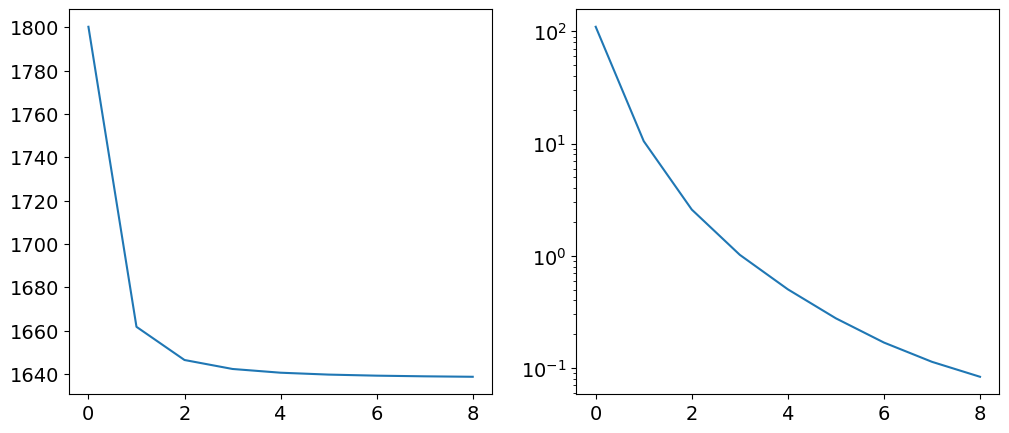

In [98]:
rank = 30
U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(fs)
axs[1].plot(deltas)
axs[1].semilogy()

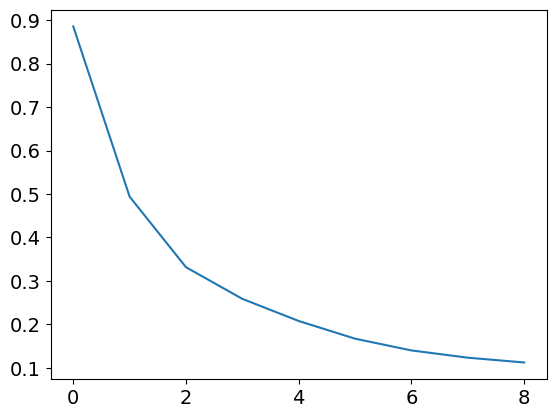

In [99]:
# опционально
plt.plot(dists)

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [100]:
#В ALS мы поддерживаем матрицу U с ортонормированными столбцами - здесь придержимся той же стратегии
A_norm = sparse_norm(A_train)

U_rand, S_rand, VT_rand = randomized_svd(A_train, n_components=30)
VT_rand=np.diag(S_rand)@VT_rand

U_sparse, S_sparse, VT_sparse = svds(A_train, k=30)
VT_sparse=np.diag(S_sparse)@VT_sparse

In [101]:
func_als=als_functional(A_train, A_norm, U_als, VT_als)
func_rand=als_functional(A_train, A_norm, U_rand, VT_rand)
func_sparse=als_functional(A_train, A_norm, U_sparse, VT_sparse)
    
print(f"Значения функционала равны: на ALS {func_als}, на randomized_svd {func_rand}, на svds {func_sparse}")

Значения функционала равны: на ALS 1638.4950276202026, на randomized_svd 1638.0012991810809, на svds 1637.8541238824992


**Комментарий:** Видим, что на ALS значение функционала (фактически, ошибки приближения) примерно равны значениям функционла на библиотечных функциях. Значит, наше приближение по данной норме сопоставимо с библиотечными функциями, ура :)

### d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `pred_am` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`pred_am` рекомендаций, то есть `pred_am` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `score_mat` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же. **Подсказка:** используйте функцию `np.argsort`.

**Объяснение:**

Знаем, что, если у нас есть ортонормированный базис (а столбцы $V^{(1)}, ..., V^{(n)}$ матрицы $V$ как раз представляют собой ортонормированный базис своей линейной оболочки, т.е. пространства $L$), то проекция $user_{ort}$ вектора $user$ на эту линейную оболочку считается по формуле: $user_{ort}=\displaystyle\sum_{i=1}^n<V^{(i)}, user>*V^{(i)}=V(V^T user)$. 

Далее для каждого пользователя мы просто сортируем его проекцию с помощью np.argsort и возвращаем из него первые pred_am значений.

In [102]:
def recommend(score_mat, pred_am, V):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array
            
        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    recs=[]
    n, r=V.shape[0], V.shape[1]
    for user in score_mat:
        user_ort= ((user@V)@V.T)[0]   #Преобразровала из (V@(V.T@user.T)).T[0]
        user_recs=np.flip(np.argsort(user_ort))[:pred_am] 
        recs.append(user_recs)    
    return np.array(recs)        

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [103]:
def evaluate_model(A_test, pred_am, V, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, V)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `pred_ams`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `pred_ams == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [104]:
def get_hit_rates(A_test, pred_ams, V):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users 
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    hit_rates=[]
    pred_am=max(pred_ams)
    hit_idx=evaluate_model(A_test, pred_am, V)
    users_num=len(hit_idx)
    for top_num in pred_ams:
        curr_hit_rate=0
        for pred_hit in hit_idx:
            if pred_hit<top_num: #Строго меньше, потому что индексы начинаются с 0, поэтому первые top_num фильмов имеют индексы 0,..., top_num-1
                curr_hit_rate+=1
        hit_rates.append(curr_hit_rate/users_num)
        
    return hit_rates     

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [105]:
A_new=A_test[:1000, :].copy()
U_sparse, S_sparse, VT_sparse = svds(A_new, k=30)
V_new=VT_sparse.T
res=get_hit_rates(A_new, [10], V_new)
print(res[0]) #hit rate действительно попадает в диапазон 12-15% (у меня он в долях)

0.12114989733059549


Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

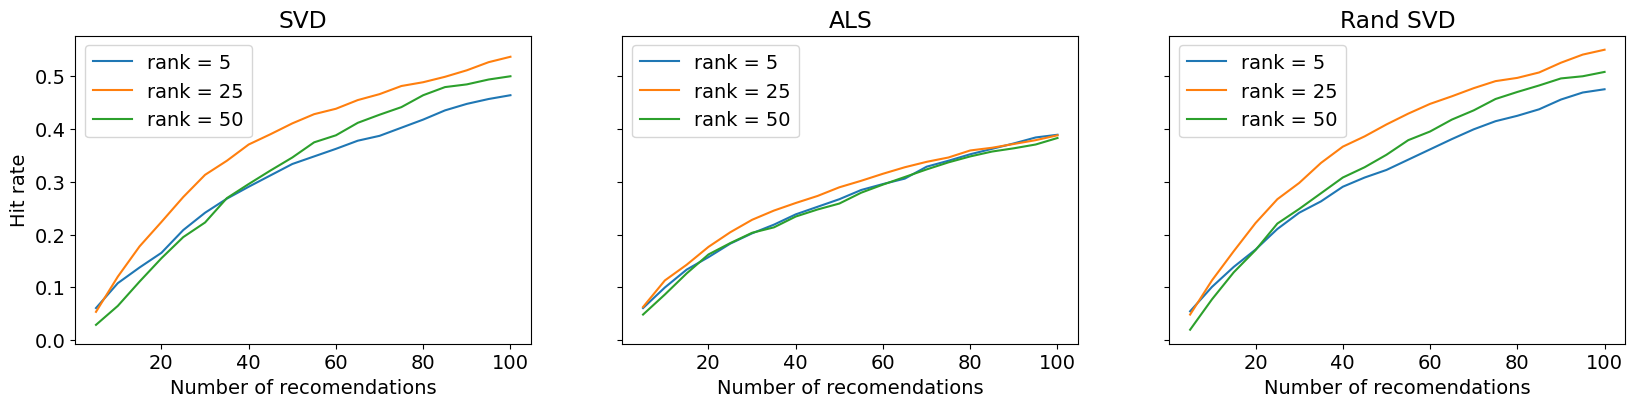

In [106]:
from scipy.sparse.linalg import svds

pred_ams = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, VT_als, _, _, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(A_test[:1000,:], pred_ams, VT.T)
        line, = ax.plot(pred_ams, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

**Комментарий:** 25 ранг оказался наиболее оптимальным для каждого алгоритма, поскольку на нем hit rate наиболее высокий.